## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [122]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` First, I read the `ab_data.csv` data. Then, I stored it in `df`.

a. Reading the dataset and take a look at the top few rows here:

In [123]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Finding the number of rows in the dataset.

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [125]:
unique_user = df['user_id'].nunique()
unique_user

290584

d. The proportion of users converted.

In [126]:
#the percentage proportion of converted users to total users
df.query('converted == 1').user_id.nunique()/df['user_id'].count()*100


11.94418598333322

e. The number of times the `new_page` and `treatment` don't match.

In [127]:
# Counting the # of time treatment and landing_page don't match
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") ').user_id.count()
    

3893

f. Finding if there are missing values.

In [128]:
#counting the null value
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, I cannot be sure if this row truly received the new or old page.  I used the cells below to figure out how we should handle these rows.  

a. Creating a new dataset that meets the specifications. I stored the new dataframe in **df2**.

In [129]:
#storing the the rows where treatment does not match with new_page or control does not match with old_page
not_matching = df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")')

#create new data frame
df2 = df.drop(not_matching.index)
df2.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [130]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Using **df2** and the cells below to answer the questions below.

a. How many unique **user_id**s are in **df2**?

In [131]:
df2['user_id'].nunique()

290584

b. Finding the repeated **user_id** in **df2**.

In [132]:
duplicated_row = df2[df2.duplicated('user_id') == True]
duplicated_row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. The row information for the repeat **user_id**? 

In [133]:
duplicated_row.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 2893 to 2893
Data columns (total 5 columns):
user_id         1 non-null int64
timestamp       1 non-null object
group           1 non-null object
landing_page    1 non-null object
converted       1 non-null int64
dtypes: int64(2), object(3)
memory usage: 48.0+ bytes


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [134]:
df2.drop(duplicated_row.index, inplace=True)

#check the # of coloumns after droping
df2.shape

(290584, 5)

`4.` Using **df2** in the cells below to answer the questions below.

a. The probability of an individual converting regardless of the page they receive.

In [135]:
df2.query('converted == 1').user_id.count()/df2['user_id'].count()

0.11959708724499628

b. Given that an individual was in the `control` group, The probability they converted is.

In [136]:
control_group = (df2.query('group == "control"')['converted'] == 1).mean()
control_group

0.1203863045004612

c. Given that an individual was in the `treatment` group, The probability they converted is.

In [137]:
treatment_group = (df2.query('group == "treatment"')['converted'] == 1).mean()
treatment_group

0.11880806551510564

d. The probability that an individual received the new page

In [138]:
df2.query('landing_page == "new_page"').user_id.nunique()/df2['user_id'].count()

0.50006194422266881

e. Considering my results from parts (a) through (d) above, I'm explaining below whether I think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>**The conversation rate shown above for the treatment group '0.119' is so close for the control group '0.120'. In this situation we can not confirm that either to go with the new page or not so we need to do more studies to be more assured.**

<a id='ab_test'></a>
### Part II - A/B Test

In This part I'm going to run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  


`1.` For now, I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should my null and alternative hypotheses be? The hypothesis terms : **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The statement would be like:**

>$H_{0}$: $p_{new}$ <= $p_{old}$ 

>$H_{1}$: $p_{new}$ > $p_{old}$


`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. The **conversion rate** for $p_{new}$ under the null? 

In [139]:
p_new = df2.query('converted == 1').user_id.count()/df2['user_id'].count()
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null? <br><br>

In [140]:
p_old = df2.query('converted == 1').user_id.count()/df2['user_id'].count()
p_old

0.11959708724499628

c. The $n_{new}$, the number of individuals in the treatment group?

In [141]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. The $n_{old}$, the number of individuals in the control group?

In [142]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [143]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17530

In [144]:
#Finding the mean of new_page_converted
new_mean = new_page_converted/n_new
new_mean

0.12063863464317666

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [145]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17351

In [146]:
#Finding the mean of old_page_converted
old_mean = old_page_converted/n_old
old_mean

0.11943637540096645

g. Finding $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [147]:
P_new_old = new_mean - old_mean
P_new_old

0.0012022592422102074

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Then I will store all 10,000 values in a NumPy array called **p_diffs**.

In [148]:
p_diffs = []
for _ in range(10000):
    p_diffs.append((np.random.binomial(n_new, p_new)/n_new)-(np.random.binomial(n_old, p_old)/n_old))

p_diffs = np.array(p_diffs)#store the values in NumPy array 

i. Ploting a histogram of the **p_diffs**.  

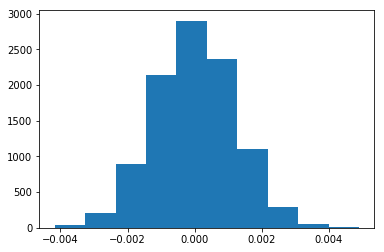

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(p_diffs); 

> The plot look like what I actully expected the distribution is normal.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [150]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)


In [151]:
# compute observed difference
obs_diff = treatment_group - control_group

# display observed difference
obs_diff

-0.0015782389853555567

In [152]:
# compute p value
(null_vals > obs_diff).mean()

0.90669999999999995

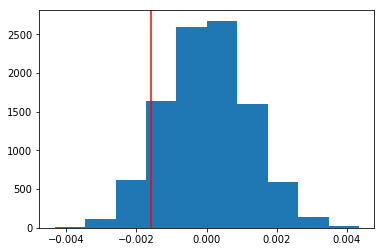

In [153]:
#plot a null distribution
plt.hist(null_vals)

#plot a line for observed statistic
plt.axvline(obs_diff, color='red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **After computing the p-value by finding the proportion of values in the null distribution that were greater than the observed difference I found that statistics does not came from the null distribution so, the difference is not significant and the null hypothesis should be rejected.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [154]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and group == "control"').shape[0]
convert_new = df2.query('converted == 1 and group == "treatment"').shape[0]
n_old = df2.query('group == "control"')['user_id'].shape[0]
n_new = df2.query('group == "treatment"')['user_id'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

*Note: The link that was posted couldn't work for me so, I used [This](http://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html) reference to help me in this part*

In [155]:
zstat, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
zstat, p_value 

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z-value = -1.3 and P-value = 0.9 in this part is almost the same as we saw before so, because the P-value < Z-value in this situation, we can agree with the what we found in the previous part and reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, The type of regression should you be performing in this case is:

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [156]:
#show the data that we already have
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [157]:
df2['intercept'] = 1 #adding the intercept
df2[['old_page', 'new_page']] = pd.get_dummies(df2['landing_page']) #creating dummy variable columns for the page

#the coloumn should count the treatment as one and the other 'control' as zero
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'] 

In [158]:
#show the data after adding new coloumns
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,new_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [159]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [160]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:31:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

> **The p-value associated with ab_page is 0.19, 
> The p-value that I got in Part II was 0.90. The p-value is too different in the two parts**

> **The reason on why the values differ is that because in Part II we focused in the hypotheses . So we specifically showed the users who converted in each page and group and the null hypotheses to be $p_{new}$ <= $p_{old}$ and the alternative hypotheses to be $p_{new}$ > $p_{old}$.**

>**But in this part, we are focusing on interpreting coefficients from logistic regression. So, the comparing here is to find that user converted is a treatment user or not so the statement is that null hypotheses to be $p_{new}$ = $p_{old}$ and the alternative hypotheses to be $p_{new}$ != $p_{old}$.**

>**So, the two parts differ regarding the directional component of the null and alternative hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Other factor would totally effect the result. For example, adding the countries as we can do below will make us understand better and can pridicts the result in more specific way. Alos, when we add the gender or the range of age that can have a good effect on the result and how the page is working from user to another.**

>**The disadvantage in adding additional terms that might increase the error rate. Also, adding too many terms will make the result hard to understand and hard to decide if the result can lead to be significant or not. In addition, progrmaticlly way adding many term can cause the a long time for fitting the process.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [161]:
#read csv file
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [162]:
df3 = df3.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,old_page,new_page,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [163]:
df3['country'].value_counts() # see countries values

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [164]:
df3['intercept'] = 1 #adding the intercept
df3[['US', 'UK', 'CA']] = pd.get_dummies(df3['country']) #creating dummy variable columns for the countries

In [165]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'US', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 May 2019   Pseudo R-squ.:               1.521e-05
Time:                        18:31:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

> The p_values' are not significant.

In [166]:
np.exp(results.params)

intercept    0.135779
US           0.960018
UK           1.009966
dtype: float64

In [167]:
1/np.exp(results.params)

intercept    7.364925
US           1.041647
UK           0.990133
dtype: float64

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [168]:
#Finding the interaction
df3['US_and_page'] = df3['US'] * df3['ab_page']
df3['UK_and_page'] = df3['UK'] * df3['ab_page']


In [169]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'US_and_page', 'UK_and_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 May 2019   Pseudo R-squ.:               2.364e-05
Time:                        18:31:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.08085
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9963      0.006   -322.049      0.000      -2.008      -1.984
US_and_page    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_and_page     0.0149      0.017      0.862      0.389      -0.019       0.049
===============================================================================
"""

> The result above shows significant p-value in the interaction between the ab_page and the US country.

### Conclusion:

> **In Conclusion we can't be assure to reject the null since the p_values' are not significant. After all the exersice that we did above we failed to reject the null so, we should accept the null hypothesis**

> **At end, we should not use the new page and keep using the old page.**

In [170]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0